# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

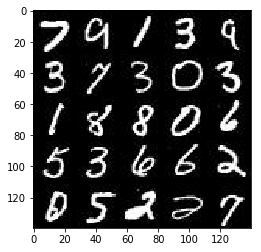

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

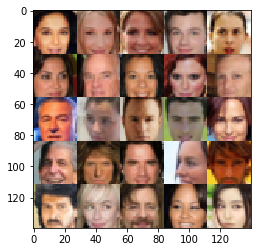

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    images = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='input_images')
    z = tf.placeholder(tf.float32, shape=(None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32)
    
    return images, z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse) as scope:
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same')
        x1 = tf.maximum(0.01*x1, x1)
        #14x14x128
        
        x2 = tf.layers.conv2d(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(0.01*x2, x2)
        #7x7x256    
        
        flat = tf.reshape(x2, (-1, 7*7*256))
        logits = tf.layers.dense(flat,1)
        output = tf.sigmoid(logits)
    
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=(not is_train)):
        x1 = tf.layers.dense(z, 7*7*256)
        
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(0.01*x1, x1)
        # 7x7x256
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(0.01*x2, x2)
        # 14x14x128
        
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3
        return tf.tanh(logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real * 0.9))
    )    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake))
    )
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake))
    )

    d_loss = d_loss_real + d_loss_fake    
    return d_loss, g_loss
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    tf.reset_default_graph()

    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)

    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    steps = 0 
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1       
                batch_images = 2 * batch_images
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Optimizers
                sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})

                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % 100 == 0:
                    show_generator_output(sess, 16, input_z, data_shape[3], data_image_mode)
                
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.6768... Generator Loss: 1.0453
Epoch 1/2... Discriminator Loss: 0.4919... Generator Loss: 1.7057
Epoch 1/2... Discriminator Loss: 0.2783... Generator Loss: 2.1893
Epoch 1/2... Discriminator Loss: 0.2127... Generator Loss: 2.3147
Epoch 1/2... Discriminator Loss: 0.3248... Generator Loss: 2.0056
Epoch 1/2... Discriminator Loss: 0.8622... Generator Loss: 0.7465
Epoch 1/2... Discriminator Loss: 0.6150... Generator Loss: 1.1860
Epoch 1/2... Discriminator Loss: 0.5246... Generator Loss: 1.3615
Epoch 1/2... Discriminator Loss: 0.6313... Generator Loss: 2.1089
Epoch 1/2... Discriminator Loss: 0.7081... Generator Loss: 2.2216


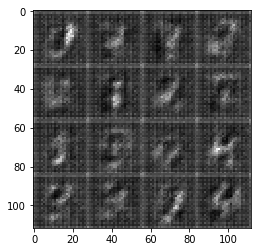

Epoch 1/2... Discriminator Loss: 0.6019... Generator Loss: 1.1903
Epoch 1/2... Discriminator Loss: 0.8450... Generator Loss: 0.7411
Epoch 1/2... Discriminator Loss: 0.7976... Generator Loss: 0.8116
Epoch 1/2... Discriminator Loss: 0.7728... Generator Loss: 2.0641
Epoch 1/2... Discriminator Loss: 0.7730... Generator Loss: 2.1586
Epoch 1/2... Discriminator Loss: 0.6935... Generator Loss: 0.9790
Epoch 1/2... Discriminator Loss: 0.6434... Generator Loss: 1.8494
Epoch 1/2... Discriminator Loss: 0.7579... Generator Loss: 0.8489
Epoch 1/2... Discriminator Loss: 0.8354... Generator Loss: 2.5312
Epoch 1/2... Discriminator Loss: 0.6399... Generator Loss: 1.2073
Epoch 1/2... Discriminator Loss: 0.5747... Generator Loss: 1.2991
Epoch 1/2... Discriminator Loss: 0.7639... Generator Loss: 0.8731
Epoch 1/2... Discriminator Loss: 0.5857... Generator Loss: 1.7357
Epoch 1/2... Discriminator Loss: 0.6284... Generator Loss: 1.2734
Epoch 1/2... Discriminator Loss: 0.5533... Generator Loss: 1.2755
Epoch 1/2.

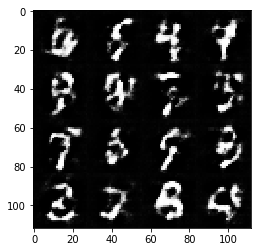

Epoch 1/2... Discriminator Loss: 0.6346... Generator Loss: 2.1746
Epoch 1/2... Discriminator Loss: 0.5769... Generator Loss: 1.8742
Epoch 1/2... Discriminator Loss: 0.6611... Generator Loss: 2.2140
Epoch 1/2... Discriminator Loss: 0.5587... Generator Loss: 1.3746
Epoch 1/2... Discriminator Loss: 0.9866... Generator Loss: 2.9515
Epoch 1/2... Discriminator Loss: 0.7281... Generator Loss: 2.5991
Epoch 1/2... Discriminator Loss: 0.6067... Generator Loss: 1.8358
Epoch 1/2... Discriminator Loss: 0.6719... Generator Loss: 1.7637
Epoch 1/2... Discriminator Loss: 0.5999... Generator Loss: 1.2491
Epoch 1/2... Discriminator Loss: 0.6370... Generator Loss: 1.5176


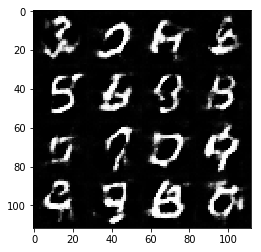

Epoch 1/2... Discriminator Loss: 0.5995... Generator Loss: 1.7590
Epoch 1/2... Discriminator Loss: 0.7401... Generator Loss: 0.9880
Epoch 1/2... Discriminator Loss: 0.7111... Generator Loss: 1.8611
Epoch 1/2... Discriminator Loss: 0.6548... Generator Loss: 1.3965
Epoch 1/2... Discriminator Loss: 0.9865... Generator Loss: 2.4620
Epoch 1/2... Discriminator Loss: 0.6438... Generator Loss: 1.1266
Epoch 2/2... Discriminator Loss: 1.0606... Generator Loss: 0.5514
Epoch 2/2... Discriminator Loss: 0.6680... Generator Loss: 1.2948
Epoch 2/2... Discriminator Loss: 0.8623... Generator Loss: 0.7422
Epoch 2/2... Discriminator Loss: 0.7126... Generator Loss: 1.4543


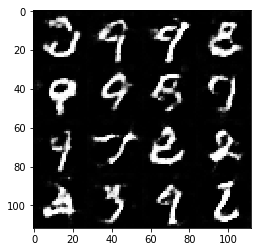

Epoch 2/2... Discriminator Loss: 0.8537... Generator Loss: 2.2082
Epoch 2/2... Discriminator Loss: 0.7569... Generator Loss: 1.0107
Epoch 2/2... Discriminator Loss: 0.7249... Generator Loss: 1.5245
Epoch 2/2... Discriminator Loss: 0.6445... Generator Loss: 1.6791
Epoch 2/2... Discriminator Loss: 0.7384... Generator Loss: 1.3720
Epoch 2/2... Discriminator Loss: 1.0169... Generator Loss: 0.6029
Epoch 2/2... Discriminator Loss: 0.6312... Generator Loss: 1.5654
Epoch 2/2... Discriminator Loss: 0.9832... Generator Loss: 0.6093
Epoch 2/2... Discriminator Loss: 0.7815... Generator Loss: 0.9579
Epoch 2/2... Discriminator Loss: 0.7039... Generator Loss: 1.0933


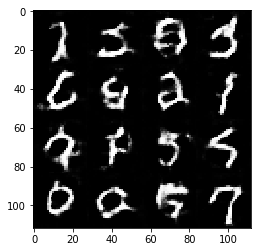

Epoch 2/2... Discriminator Loss: 0.7785... Generator Loss: 0.8566
Epoch 2/2... Discriminator Loss: 0.9707... Generator Loss: 1.9930
Epoch 2/2... Discriminator Loss: 0.7320... Generator Loss: 1.1183
Epoch 2/2... Discriminator Loss: 0.6940... Generator Loss: 1.4134
Epoch 2/2... Discriminator Loss: 0.6578... Generator Loss: 1.5314
Epoch 2/2... Discriminator Loss: 0.6810... Generator Loss: 1.1382
Epoch 2/2... Discriminator Loss: 0.7448... Generator Loss: 1.1594
Epoch 2/2... Discriminator Loss: 1.2947... Generator Loss: 0.4118
Epoch 2/2... Discriminator Loss: 0.7012... Generator Loss: 1.3325
Epoch 2/2... Discriminator Loss: 0.8099... Generator Loss: 1.0578


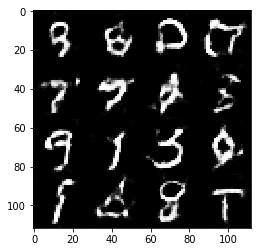

Epoch 2/2... Discriminator Loss: 0.7703... Generator Loss: 0.8654
Epoch 2/2... Discriminator Loss: 0.6734... Generator Loss: 1.4704
Epoch 2/2... Discriminator Loss: 0.8027... Generator Loss: 2.2955
Epoch 2/2... Discriminator Loss: 0.7330... Generator Loss: 1.6106
Epoch 2/2... Discriminator Loss: 0.7569... Generator Loss: 0.9483
Epoch 2/2... Discriminator Loss: 0.7214... Generator Loss: 1.0134
Epoch 2/2... Discriminator Loss: 0.6661... Generator Loss: 1.4809
Epoch 2/2... Discriminator Loss: 1.0418... Generator Loss: 2.2949
Epoch 2/2... Discriminator Loss: 0.7677... Generator Loss: 1.2058
Epoch 2/2... Discriminator Loss: 0.8087... Generator Loss: 0.8261


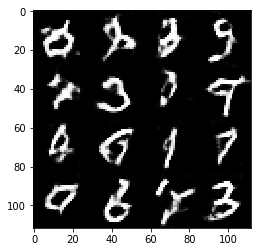

Epoch 2/2... Discriminator Loss: 0.7451... Generator Loss: 1.0610
Epoch 2/2... Discriminator Loss: 0.6604... Generator Loss: 1.4341
Epoch 2/2... Discriminator Loss: 0.6557... Generator Loss: 1.7498
Epoch 2/2... Discriminator Loss: 0.7018... Generator Loss: 1.3915
Epoch 2/2... Discriminator Loss: 0.7113... Generator Loss: 1.0236
Epoch 2/2... Discriminator Loss: 0.6402... Generator Loss: 1.4652
Epoch 2/2... Discriminator Loss: 1.0654... Generator Loss: 0.5736
Epoch 2/2... Discriminator Loss: 0.7853... Generator Loss: 1.5035
Epoch 2/2... Discriminator Loss: 0.7634... Generator Loss: 0.9549
Epoch 2/2... Discriminator Loss: 0.6958... Generator Loss: 1.0959


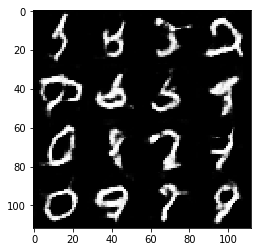

Epoch 2/2... Discriminator Loss: 0.6967... Generator Loss: 1.0370
Epoch 2/2... Discriminator Loss: 0.6788... Generator Loss: 1.1730
Epoch 2/2... Discriminator Loss: 0.7411... Generator Loss: 0.9959


In [ ]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.4347... Generator Loss: 1.3521
Epoch 1/1... Discriminator Loss: 0.1870... Generator Loss: 2.5001
Epoch 1/1... Discriminator Loss: 0.1729... Generator Loss: 2.3748
Epoch 1/1... Discriminator Loss: 0.2439... Generator Loss: 2.0067
Epoch 1/1... Discriminator Loss: 0.6983... Generator Loss: 6.3649
Epoch 1/1... Discriminator Loss: 2.1217... Generator Loss: 0.1929
Epoch 1/1... Discriminator Loss: 0.6376... Generator Loss: 1.1965
Epoch 1/1... Discriminator Loss: 0.6853... Generator Loss: 2.3621
Epoch 1/1... Discriminator Loss: 0.4973... Generator Loss: 1.7615
Epoch 1/1... Discriminator Loss: 0.7092... Generator Loss: 1.3963


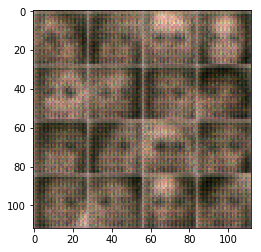

Epoch 1/1... Discriminator Loss: 0.5137... Generator Loss: 1.4831
Epoch 1/1... Discriminator Loss: 0.4492... Generator Loss: 1.4274
Epoch 1/1... Discriminator Loss: 0.5269... Generator Loss: 1.3689
Epoch 1/1... Discriminator Loss: 0.7214... Generator Loss: 1.4644
Epoch 1/1... Discriminator Loss: 1.2891... Generator Loss: 0.4820
Epoch 1/1... Discriminator Loss: 1.0591... Generator Loss: 0.7030
Epoch 1/1... Discriminator Loss: 0.5197... Generator Loss: 1.3959
Epoch 1/1... Discriminator Loss: 0.6881... Generator Loss: 1.1032
Epoch 1/1... Discriminator Loss: 0.7486... Generator Loss: 1.3658
Epoch 1/1... Discriminator Loss: 0.8027... Generator Loss: 0.9034


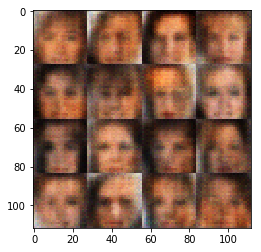

Epoch 1/1... Discriminator Loss: 0.9192... Generator Loss: 0.6985
Epoch 1/1... Discriminator Loss: 0.6510... Generator Loss: 1.3079
Epoch 1/1... Discriminator Loss: 0.6806... Generator Loss: 1.0993
Epoch 1/1... Discriminator Loss: 1.3336... Generator Loss: 2.9462
Epoch 1/1... Discriminator Loss: 0.4690... Generator Loss: 1.8338
Epoch 1/1... Discriminator Loss: 0.5566... Generator Loss: 2.1519
Epoch 1/1... Discriminator Loss: 0.6383... Generator Loss: 1.1296
Epoch 1/1... Discriminator Loss: 0.6723... Generator Loss: 1.2013
Epoch 1/1... Discriminator Loss: 0.5678... Generator Loss: 1.9884
Epoch 1/1... Discriminator Loss: 0.6689... Generator Loss: 1.0577


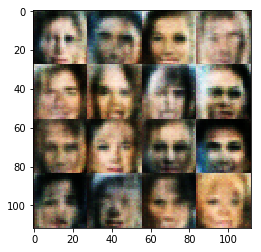

Epoch 1/1... Discriminator Loss: 0.3634... Generator Loss: 1.7348
Epoch 1/1... Discriminator Loss: 0.5933... Generator Loss: 1.8529
Epoch 1/1... Discriminator Loss: 1.3288... Generator Loss: 3.0678
Epoch 1/1... Discriminator Loss: 0.7431... Generator Loss: 1.4056
Epoch 1/1... Discriminator Loss: 0.4726... Generator Loss: 1.5960
Epoch 1/1... Discriminator Loss: 0.5790... Generator Loss: 2.4120
Epoch 1/1... Discriminator Loss: 0.5742... Generator Loss: 1.5714
Epoch 1/1... Discriminator Loss: 0.5645... Generator Loss: 1.6989
Epoch 1/1... Discriminator Loss: 0.5732... Generator Loss: 1.8472
Epoch 1/1... Discriminator Loss: 0.7771... Generator Loss: 2.2096


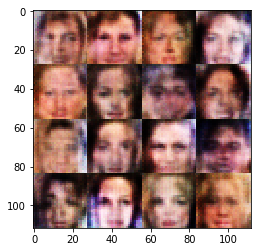

Epoch 1/1... Discriminator Loss: 0.7079... Generator Loss: 1.0951
Epoch 1/1... Discriminator Loss: 0.6156... Generator Loss: 1.3470
Epoch 1/1... Discriminator Loss: 0.9670... Generator Loss: 0.7172
Epoch 1/1... Discriminator Loss: 1.2699... Generator Loss: 2.6399
Epoch 1/1... Discriminator Loss: 0.5164... Generator Loss: 2.5372
Epoch 1/1... Discriminator Loss: 0.7857... Generator Loss: 1.8681
Epoch 1/1... Discriminator Loss: 0.9585... Generator Loss: 1.6700
Epoch 1/1... Discriminator Loss: 0.8766... Generator Loss: 0.7713
Epoch 1/1... Discriminator Loss: 1.3085... Generator Loss: 0.4253
Epoch 1/1... Discriminator Loss: 0.8496... Generator Loss: 0.8441


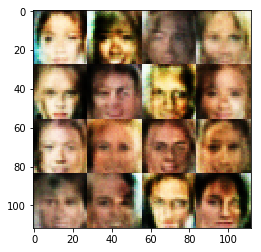

Epoch 1/1... Discriminator Loss: 0.5680... Generator Loss: 1.4708
Epoch 1/1... Discriminator Loss: 0.7773... Generator Loss: 1.1202
Epoch 1/1... Discriminator Loss: 0.7491... Generator Loss: 1.5330
Epoch 1/1... Discriminator Loss: 0.7765... Generator Loss: 1.3106
Epoch 1/1... Discriminator Loss: 1.1966... Generator Loss: 1.8024
Epoch 1/1... Discriminator Loss: 1.1160... Generator Loss: 2.0517
Epoch 1/1... Discriminator Loss: 0.8733... Generator Loss: 2.5468
Epoch 1/1... Discriminator Loss: 0.6744... Generator Loss: 1.2427
Epoch 1/1... Discriminator Loss: 1.0497... Generator Loss: 0.6305
Epoch 1/1... Discriminator Loss: 0.9326... Generator Loss: 1.7983


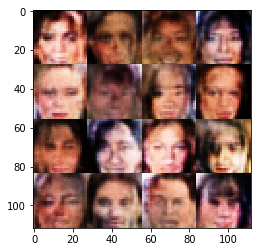

Epoch 1/1... Discriminator Loss: 0.7190... Generator Loss: 0.9879
Epoch 1/1... Discriminator Loss: 0.6598... Generator Loss: 1.3335
Epoch 1/1... Discriminator Loss: 0.7843... Generator Loss: 1.1075
Epoch 1/1... Discriminator Loss: 0.9299... Generator Loss: 1.9791
Epoch 1/1... Discriminator Loss: 0.7316... Generator Loss: 1.0590
Epoch 1/1... Discriminator Loss: 0.8081... Generator Loss: 1.1416
Epoch 1/1... Discriminator Loss: 1.4288... Generator Loss: 0.3551
Epoch 1/1... Discriminator Loss: 0.7838... Generator Loss: 2.5920
Epoch 1/1... Discriminator Loss: 0.6428... Generator Loss: 1.1638
Epoch 1/1... Discriminator Loss: 1.1029... Generator Loss: 2.2392


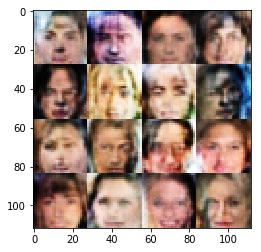

Epoch 1/1... Discriminator Loss: 0.7700... Generator Loss: 2.3950
Epoch 1/1... Discriminator Loss: 0.5999... Generator Loss: 1.4061
Epoch 1/1... Discriminator Loss: 0.7165... Generator Loss: 3.0421
Epoch 1/1... Discriminator Loss: 1.0526... Generator Loss: 1.8544
Epoch 1/1... Discriminator Loss: 1.0529... Generator Loss: 0.5959
Epoch 1/1... Discriminator Loss: 0.7926... Generator Loss: 0.9378
Epoch 1/1... Discriminator Loss: 0.5949... Generator Loss: 1.2196
Epoch 1/1... Discriminator Loss: 1.6221... Generator Loss: 0.2863
Epoch 1/1... Discriminator Loss: 0.7619... Generator Loss: 1.4079
Epoch 1/1... Discriminator Loss: 0.7898... Generator Loss: 1.5769


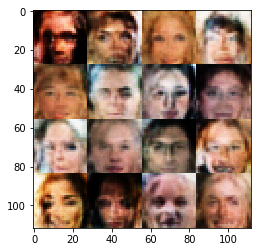

Epoch 1/1... Discriminator Loss: 0.5990... Generator Loss: 1.4565
Epoch 1/1... Discriminator Loss: 0.4940... Generator Loss: 2.3233
Epoch 1/1... Discriminator Loss: 0.4687... Generator Loss: 1.4648
Epoch 1/1... Discriminator Loss: 0.6868... Generator Loss: 2.3342
Epoch 1/1... Discriminator Loss: 0.4552... Generator Loss: 1.5341
Epoch 1/1... Discriminator Loss: 1.1133... Generator Loss: 2.2529
Epoch 1/1... Discriminator Loss: 0.6929... Generator Loss: 1.1570
Epoch 1/1... Discriminator Loss: 0.8215... Generator Loss: 2.6231
Epoch 1/1... Discriminator Loss: 0.7263... Generator Loss: 0.9586
Epoch 1/1... Discriminator Loss: 0.6664... Generator Loss: 1.0280


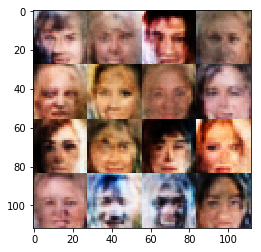

Epoch 1/1... Discriminator Loss: 0.6258... Generator Loss: 1.8953
Epoch 1/1... Discriminator Loss: 0.3304... Generator Loss: 2.4204
Epoch 1/1... Discriminator Loss: 0.6447... Generator Loss: 1.0456
Epoch 1/1... Discriminator Loss: 0.7845... Generator Loss: 3.7403
Epoch 1/1... Discriminator Loss: 0.7260... Generator Loss: 1.2804
Epoch 1/1... Discriminator Loss: 0.4802... Generator Loss: 1.3481
Epoch 1/1... Discriminator Loss: 1.4567... Generator Loss: 0.3499
Epoch 1/1... Discriminator Loss: 0.5910... Generator Loss: 3.0722
Epoch 1/1... Discriminator Loss: 1.3168... Generator Loss: 0.4527
Epoch 1/1... Discriminator Loss: 0.6246... Generator Loss: 2.0071


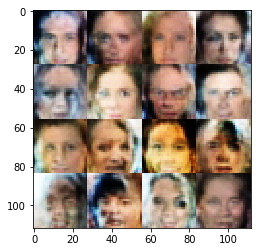

Epoch 1/1... Discriminator Loss: 1.1121... Generator Loss: 3.2847
Epoch 1/1... Discriminator Loss: 1.2097... Generator Loss: 0.4871
Epoch 1/1... Discriminator Loss: 0.9056... Generator Loss: 1.4179
Epoch 1/1... Discriminator Loss: 0.5542... Generator Loss: 1.6220
Epoch 1/1... Discriminator Loss: 0.3612... Generator Loss: 3.5084
Epoch 1/1... Discriminator Loss: 0.7169... Generator Loss: 0.9093
Epoch 1/1... Discriminator Loss: 0.6805... Generator Loss: 0.9071
Epoch 1/1... Discriminator Loss: 1.2056... Generator Loss: 0.5139
Epoch 1/1... Discriminator Loss: 0.6673... Generator Loss: 0.9994
Epoch 1/1... Discriminator Loss: 0.5400... Generator Loss: 1.2616


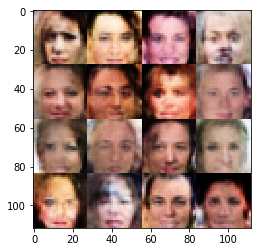

Epoch 1/1... Discriminator Loss: 0.4869... Generator Loss: 3.0898
Epoch 1/1... Discriminator Loss: 0.5680... Generator Loss: 1.1438
Epoch 1/1... Discriminator Loss: 0.8844... Generator Loss: 2.6523
Epoch 1/1... Discriminator Loss: 0.4695... Generator Loss: 2.8488
Epoch 1/1... Discriminator Loss: 0.8733... Generator Loss: 2.5375
Epoch 1/1... Discriminator Loss: 0.5567... Generator Loss: 1.6120
Epoch 1/1... Discriminator Loss: 0.5755... Generator Loss: 2.0133
Epoch 1/1... Discriminator Loss: 0.7585... Generator Loss: 1.0217
Epoch 1/1... Discriminator Loss: 1.1032... Generator Loss: 1.4940
Epoch 1/1... Discriminator Loss: 1.9596... Generator Loss: 0.1980


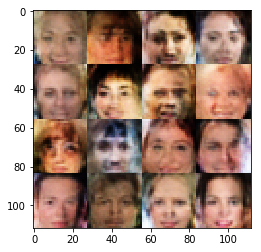

Epoch 1/1... Discriminator Loss: 0.6317... Generator Loss: 1.1820
Epoch 1/1... Discriminator Loss: 0.3916... Generator Loss: 2.3505
Epoch 1/1... Discriminator Loss: 0.3968... Generator Loss: 2.2675
Epoch 1/1... Discriminator Loss: 0.1849... Generator Loss: 3.4485
Epoch 1/1... Discriminator Loss: 1.1633... Generator Loss: 0.5303
Epoch 1/1... Discriminator Loss: 0.2922... Generator Loss: 2.6743
Epoch 1/1... Discriminator Loss: 0.3931... Generator Loss: 1.5502
Epoch 1/1... Discriminator Loss: 1.0544... Generator Loss: 2.1821
Epoch 1/1... Discriminator Loss: 0.7373... Generator Loss: 0.9768
Epoch 1/1... Discriminator Loss: 0.3068... Generator Loss: 1.9091


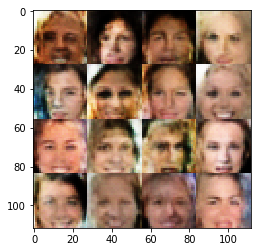

Epoch 1/1... Discriminator Loss: 0.4311... Generator Loss: 1.9458
Epoch 1/1... Discriminator Loss: 0.3618... Generator Loss: 3.5794
Epoch 1/1... Discriminator Loss: 0.7727... Generator Loss: 1.9124
Epoch 1/1... Discriminator Loss: 0.5501... Generator Loss: 1.3233
Epoch 1/1... Discriminator Loss: 0.7827... Generator Loss: 0.8042
Epoch 1/1... Discriminator Loss: 1.1318... Generator Loss: 0.6215
Epoch 1/1... Discriminator Loss: 0.2345... Generator Loss: 3.6010
Epoch 1/1... Discriminator Loss: 0.4270... Generator Loss: 2.8353
Epoch 1/1... Discriminator Loss: 0.5683... Generator Loss: 1.0910
Epoch 1/1... Discriminator Loss: 0.4356... Generator Loss: 1.3906


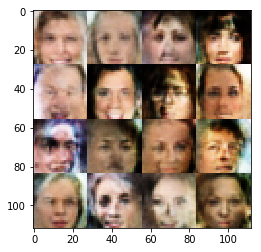

Epoch 1/1... Discriminator Loss: 1.0202... Generator Loss: 0.6457
Epoch 1/1... Discriminator Loss: 0.4374... Generator Loss: 2.1012
Epoch 1/1... Discriminator Loss: 1.2019... Generator Loss: 0.4789
Epoch 1/1... Discriminator Loss: 1.3031... Generator Loss: 0.3933
Epoch 1/1... Discriminator Loss: 0.4463... Generator Loss: 1.3966
Epoch 1/1... Discriminator Loss: 1.9247... Generator Loss: 2.6385
Epoch 1/1... Discriminator Loss: 1.0505... Generator Loss: 1.0436
Epoch 1/1... Discriminator Loss: 0.8999... Generator Loss: 0.7393
Epoch 1/1... Discriminator Loss: 0.6427... Generator Loss: 1.1224
Epoch 1/1... Discriminator Loss: 0.5898... Generator Loss: 1.0941


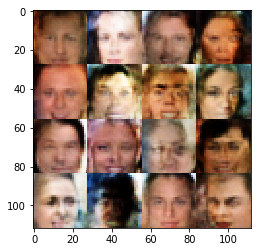

Epoch 1/1... Discriminator Loss: 0.4110... Generator Loss: 2.3986
Epoch 1/1... Discriminator Loss: 0.8461... Generator Loss: 3.1385
Epoch 1/1... Discriminator Loss: 1.0817... Generator Loss: 1.0861
Epoch 1/1... Discriminator Loss: 0.5460... Generator Loss: 2.4417
Epoch 1/1... Discriminator Loss: 0.4565... Generator Loss: 1.7434
Epoch 1/1... Discriminator Loss: 0.3846... Generator Loss: 1.5046
Epoch 1/1... Discriminator Loss: 0.2498... Generator Loss: 2.2147
Epoch 1/1... Discriminator Loss: 0.7749... Generator Loss: 0.8270


In [13]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.